<a href="https://colab.research.google.com/github/Jac-Zac/PML_DL_Final_Project/blob/main/notebooks/notebook_train_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧙‍♂️ Training diffusion model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jac-Zac/PML_DL_Final_Project/blob/master/notebooks/notebook_train_flow.ipynb)

### Initial setup ⚙️

In [1]:
!git fetch https://github.com/Jac-Zac/PML_DL_Final_Project.git

fatal: not a git repository (or any of the parent directories): .git


In [2]:
import os

repo_dir = "PML_DL_Final_Project"

if not os.path.exists(repo_dir):
    !git clone https://github.com/Jac-Zac/PML_DL_Final_Project.git
else:
    print(f"Repository '{repo_dir}' already exists. Skipping clone.")

Cloning into 'PML_DL_Final_Project'...
remote: Enumerating objects: 836, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 836 (delta 174), reused 194 (delta 95), pack-reused 542 (from 1)
Receiving objects: 100% (836/836), 5.60 MiB | 21.54 MiB/s, done.
Resolving deltas: 100% (498/498), done.


In [3]:
if os.path.isdir(repo_dir):
    %cd $repo_dir
    !pip install dotenv -q
else:
    print(f"Directory '{repo_dir}' not found. Please clone the repository first.")

/content/PML_DL_Final_Project


### 📦 Imports

In [4]:
import torch
import numpy as np

from src.train.train import train
from src.utils.data import get_dataloaders
from src.utils.plots import plot_image_grid
from src.utils.environment import get_device, set_seed, load_pretrained_model

from src.models.flow import FlowMatching

# Since on a notebook we can have nicer bars
from tqdm.notebook import tqdm as tqdm_notebook

/content/PML_DL_Final_Project/src/train/train.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### 🛠️ Configuration Parameters

In [5]:
epochs = 20
batch_size = 128
learning_rate = 1e-3
seed = 1337
checkpoint_path = "checkpoints/last.ckpt"
model_name = "unet"
method = "flow"  # or "flow"
dataset_name = "FashionMNIST"

### 🧪 Setup: Seed and Device

In [6]:
set_seed(seed)
device = get_device()
os.makedirs("checkpoints", exist_ok=True)

## 🧠 Model Training

#### 📥 Data Loading

In [7]:
# Returns DataLoaders that yield (image, timestep, label)
train_loader, val_loader = get_dataloaders(batch_size=batch_size, dataset_name=dataset_name)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 217kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.02MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.74MB/s]


#### Training

In [8]:
# NOTE: Currently assumes 10 classes are hardcoded
num_classes = 10
# HACK: Hard-coded number of classes (MNIST = 10) / FashionMNIST
model_kwargs = {
    "num_classes": 10,
    "out_channels": 1,
    "time_emb_dim": 128,
    # NOTE: Change time embedding to learned for flow which is more sensible
    "time_embedding_type": "mlp" if method == "flow" else "sinusoidal",
}


In [9]:
flow_model = train(
    num_epochs=epochs,
    device= device,
    dataloader = train_loader,
    val_loader = val_loader,
    use_wandb = True,
    checkpoint_path = checkpoint_path,
    model_kwargs = model_kwargs,
    method = method
)

WANDB_API_KEY environment variable not set. Please enter your WandB API key: d8dc3ad9caae0ce9504bfcf61be898d8fbdbef18


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jacopozac (jac-zac) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Epoch 1/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 1.0753 | Val Loss: 0.7761 | LR: 0.000994
New best model saved! Epoch 1, Val Loss: 0.7761

Epoch 2/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.7338 | Val Loss: 0.7092 | LR: 0.000976
New best model saved! Epoch 2, Val Loss: 0.7092

Epoch 3/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.6865 | Val Loss: 0.6909 | LR: 0.000946
New best model saved! Epoch 3, Val Loss: 0.6909

Epoch 4/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.6614 | Val Loss: 0.6749 | LR: 0.000905
New best model saved! Epoch 4, Val Loss: 0.6749

Epoch 5/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.6439 | Val Loss: 0.6397 | LR: 0.000855
New best model saved! Epoch 5, Val Loss: 0.6397

Epoch 6/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.6321 | Val Loss: 0.6435 | LR: 0.000796

Epoch 7/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.6230 | Val Loss: 0.6297 | LR: 0.000730
New best model saved! Epoch 7, Val Loss: 0.6297

Epoch 8/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.6142 | Val Loss: 0.6131 | LR: 0.000658
New best model saved! Epoch 8, Val Loss: 0.6131

Epoch 9/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.6065 | Val Loss: 0.6176 | LR: 0.000582

Epoch 10/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.6020 | Val Loss: 0.6041 | LR: 0.000505
New best model saved! Epoch 10, Val Loss: 0.6041

Epoch 11/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5978 | Val Loss: 0.5983 | LR: 0.000428
New best model saved! Epoch 11, Val Loss: 0.5983

Epoch 12/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5929 | Val Loss: 0.5961 | LR: 0.000352
New best model saved! Epoch 12, Val Loss: 0.5961

Epoch 13/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5887 | Val Loss: 0.5868 | LR: 0.000280
New best model saved! Epoch 13, Val Loss: 0.5868

Epoch 14/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5848 | Val Loss: 0.5840 | LR: 0.000214
New best model saved! Epoch 14, Val Loss: 0.5840

Epoch 15/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5766 | Val Loss: 0.5877 | LR: 0.000155

Epoch 16/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5759 | Val Loss: 0.5890 | LR: 0.000105

Epoch 17/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5741 | Val Loss: 0.5946 | LR: 0.000064

Epoch 18/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5732 | Val Loss: 0.5726 | LR: 0.000034
New best model saved! Epoch 18, Val Loss: 0.5726

Epoch 19/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5708 | Val Loss: 0.5660 | LR: 0.000016
New best model saved! Epoch 19, Val Loss: 0.5660

Epoch 20/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5682 | Val Loss: 0.5759 | LR: 0.000010


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
train/loss_epoch,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/loss_step,▆█▆▅▅▄▄▂▃▃▃▄▃▄▃▃▄▃▂▁▂▂▂▂▂▂▂▃▂▂▂▃▄▂▂▂▁▂▂▂
val/loss,█▆▅▅▃▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁
best_train_loss,0.57075
best_val_epoch,19
best_val_loss,0.56597
best_val_lr,2e-05
epoch,20
learning_rate,1e-05



Training complete. Best validation loss: 0.5660


## 💡 Image Generation

#### 🛠️ Configuration Parameters

In [10]:
n_samples = 5     #number of classes I want to sample
save_dir = "samples"
num_steps = 10
num_intermediate = 10

ckpt_path = "checkpoints/best_model.pth"  # or use your last checkpoint

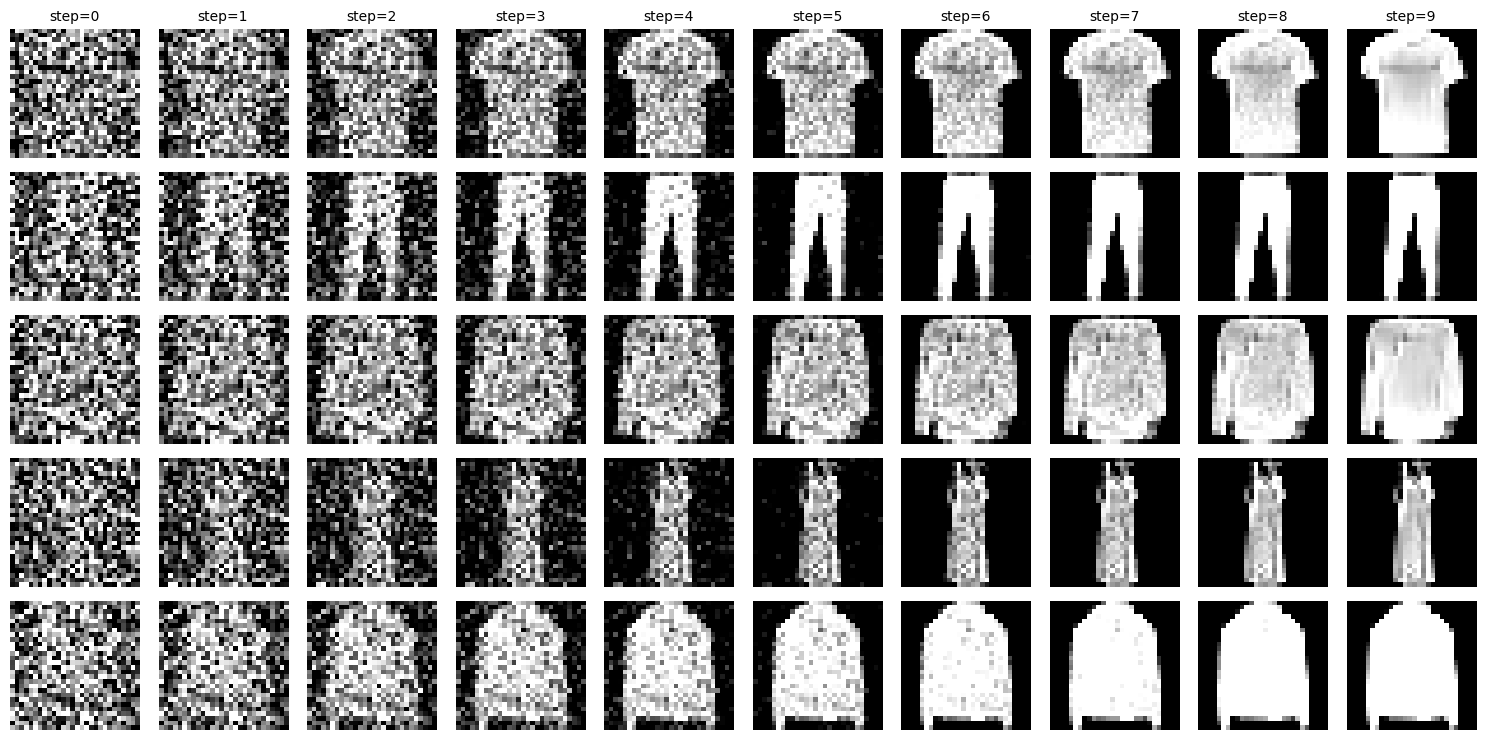

In [11]:
from PIL import Image
import os
import matplotlib.pyplot as plt

# Create sampler instance
flow = FlowMatching(img_size=28, device=device)

# Call the plotting function (note argument order!)
plot_image_grid(
    model=flow_model,
    method_instance=flow,
    n=n_samples,
    num_intermediate=num_intermediate,
    num_steps=num_steps,
    save_dir=save_dir,
    device=device,
    num_classes=num_classes,
)

# Display the saved image
out_path = os.path.join(save_dir, "all_samples_grid.png")
display(Image.open(out_path))